<h1 id="Contents">Contents<a href="#Contents"></a></h1>
        <ol>
        <li><a class="" href="#Imports">Imports</a></li>
<li><a class="" href="#Defining-the-Data-Directory-and-Result-Directory">Defining the Data Directory and Result Directory</a></li>
<li><a class="" href="#Initializing-the-Classes">Initializing the Classes</a></li>
<li><a class="" href="#Extracting-Information">Extracting Information</a></li>
<ol><li><a class="" href="#Determining-the-Region-of-Interest">Determining the Region of Interest</a></li>
<li><a class="" href="#Reiniatilizing-the-Classes">Reiniatilizing the Classes</a></li>
<li><a class="" href="#Setting-the-Reference-Image">Setting the Reference Image</a></li>
<li><a class="" href="#Extracting-Center-Related-Information">Extracting Center Related Information</a></li>
<li><a class="" href="#Some-Preliminary-Analysis">Some Preliminary Analysis</a></li>
<ol><li><a class="" href="#None-Values">None Values</a></li>
<li><a class="" href="#Sample-Images">Sample Images</a></li>
</ol><li><a class="" href="#Extracting-Objectives">Extracting Objectives</a></li>
<ol><li><a class="" href="#Getting-Frame-Information">Getting Frame Information</a></li>
<li><a class="" href="#Getting-Angle-and-Velocity">Getting Angle and Velocity</a></li>
<li><a class="" href="#The-Additional-Information">The Additional Information</a></li>
<li><a class="" href="#Adding-the-Additional-Information">Adding the Additional Information</a></li>
<li><a class="" href="#Save-the-DataFrame">Save the DataFrame</a></li>
</ol>

# Imports

In [91]:
from extract_center import CenterExtracter
from run import Run
from misc_tools import Plotter, Smoother
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Defining the Data Directory and Result Directory

In [92]:
sequence = "h2"
DATA_DIR = '../../data/extracted_images/' + sequence
RESULT_DIR = '../../data/results/' + sequence

# Initializing the Classes

In [93]:
run = Run(DATA_DIR, RESULT_DIR)
ce = CenterExtracter()

# Extracting Information

## Determining the *Region of Interest*

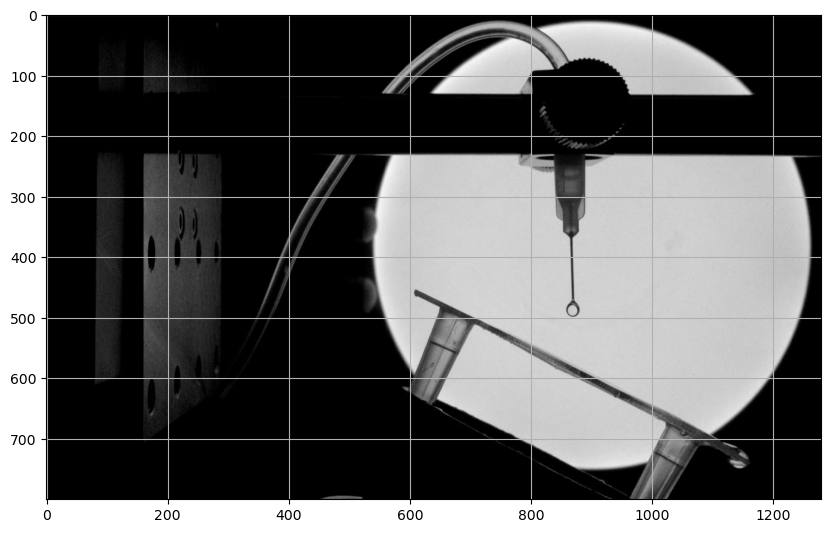

In [94]:
images = run.get_images()
img_1 = ce._read_image(images[0])
ce._show_image(img_1)

In [95]:
region_of_interset = (700, 350, 1200, 700)

## Reiniatilizing the Classes

In [96]:
run = Run(DATA_DIR, RESULT_DIR, region = region_of_interset)

## Setting the Reference Image

In [97]:
run._set_ref_image(-10)

## Extracting Center Related Information

In [98]:
df = run.all_points(crop_included=True, binary=True, verbose=False, num_images=None, raise_error=False)

Getting list of images...
Extracting data from images...


Extracting data from images: 100%|██████████| 300/300 [00:23<00:00, 13.01it/s]


Saving to csv...
Done!


## Some Preliminary Analysis

### None Values

In [99]:
df.isna().sum()

id         0
x        130
y        130
r1       130
r2       130
theta    130
dtype: int64

In [100]:
none_values = df.isna().sum()["x"]
total_frames = len(df)
unrealistic = len(df[((df["r1"]+df["r2"])/2>20)|((df["r1"]+df["r2"])/2<5)])

In [101]:
df = pd.read_csv(RESULT_DIR + '/centers_using_ap.csv')

### Sample Images

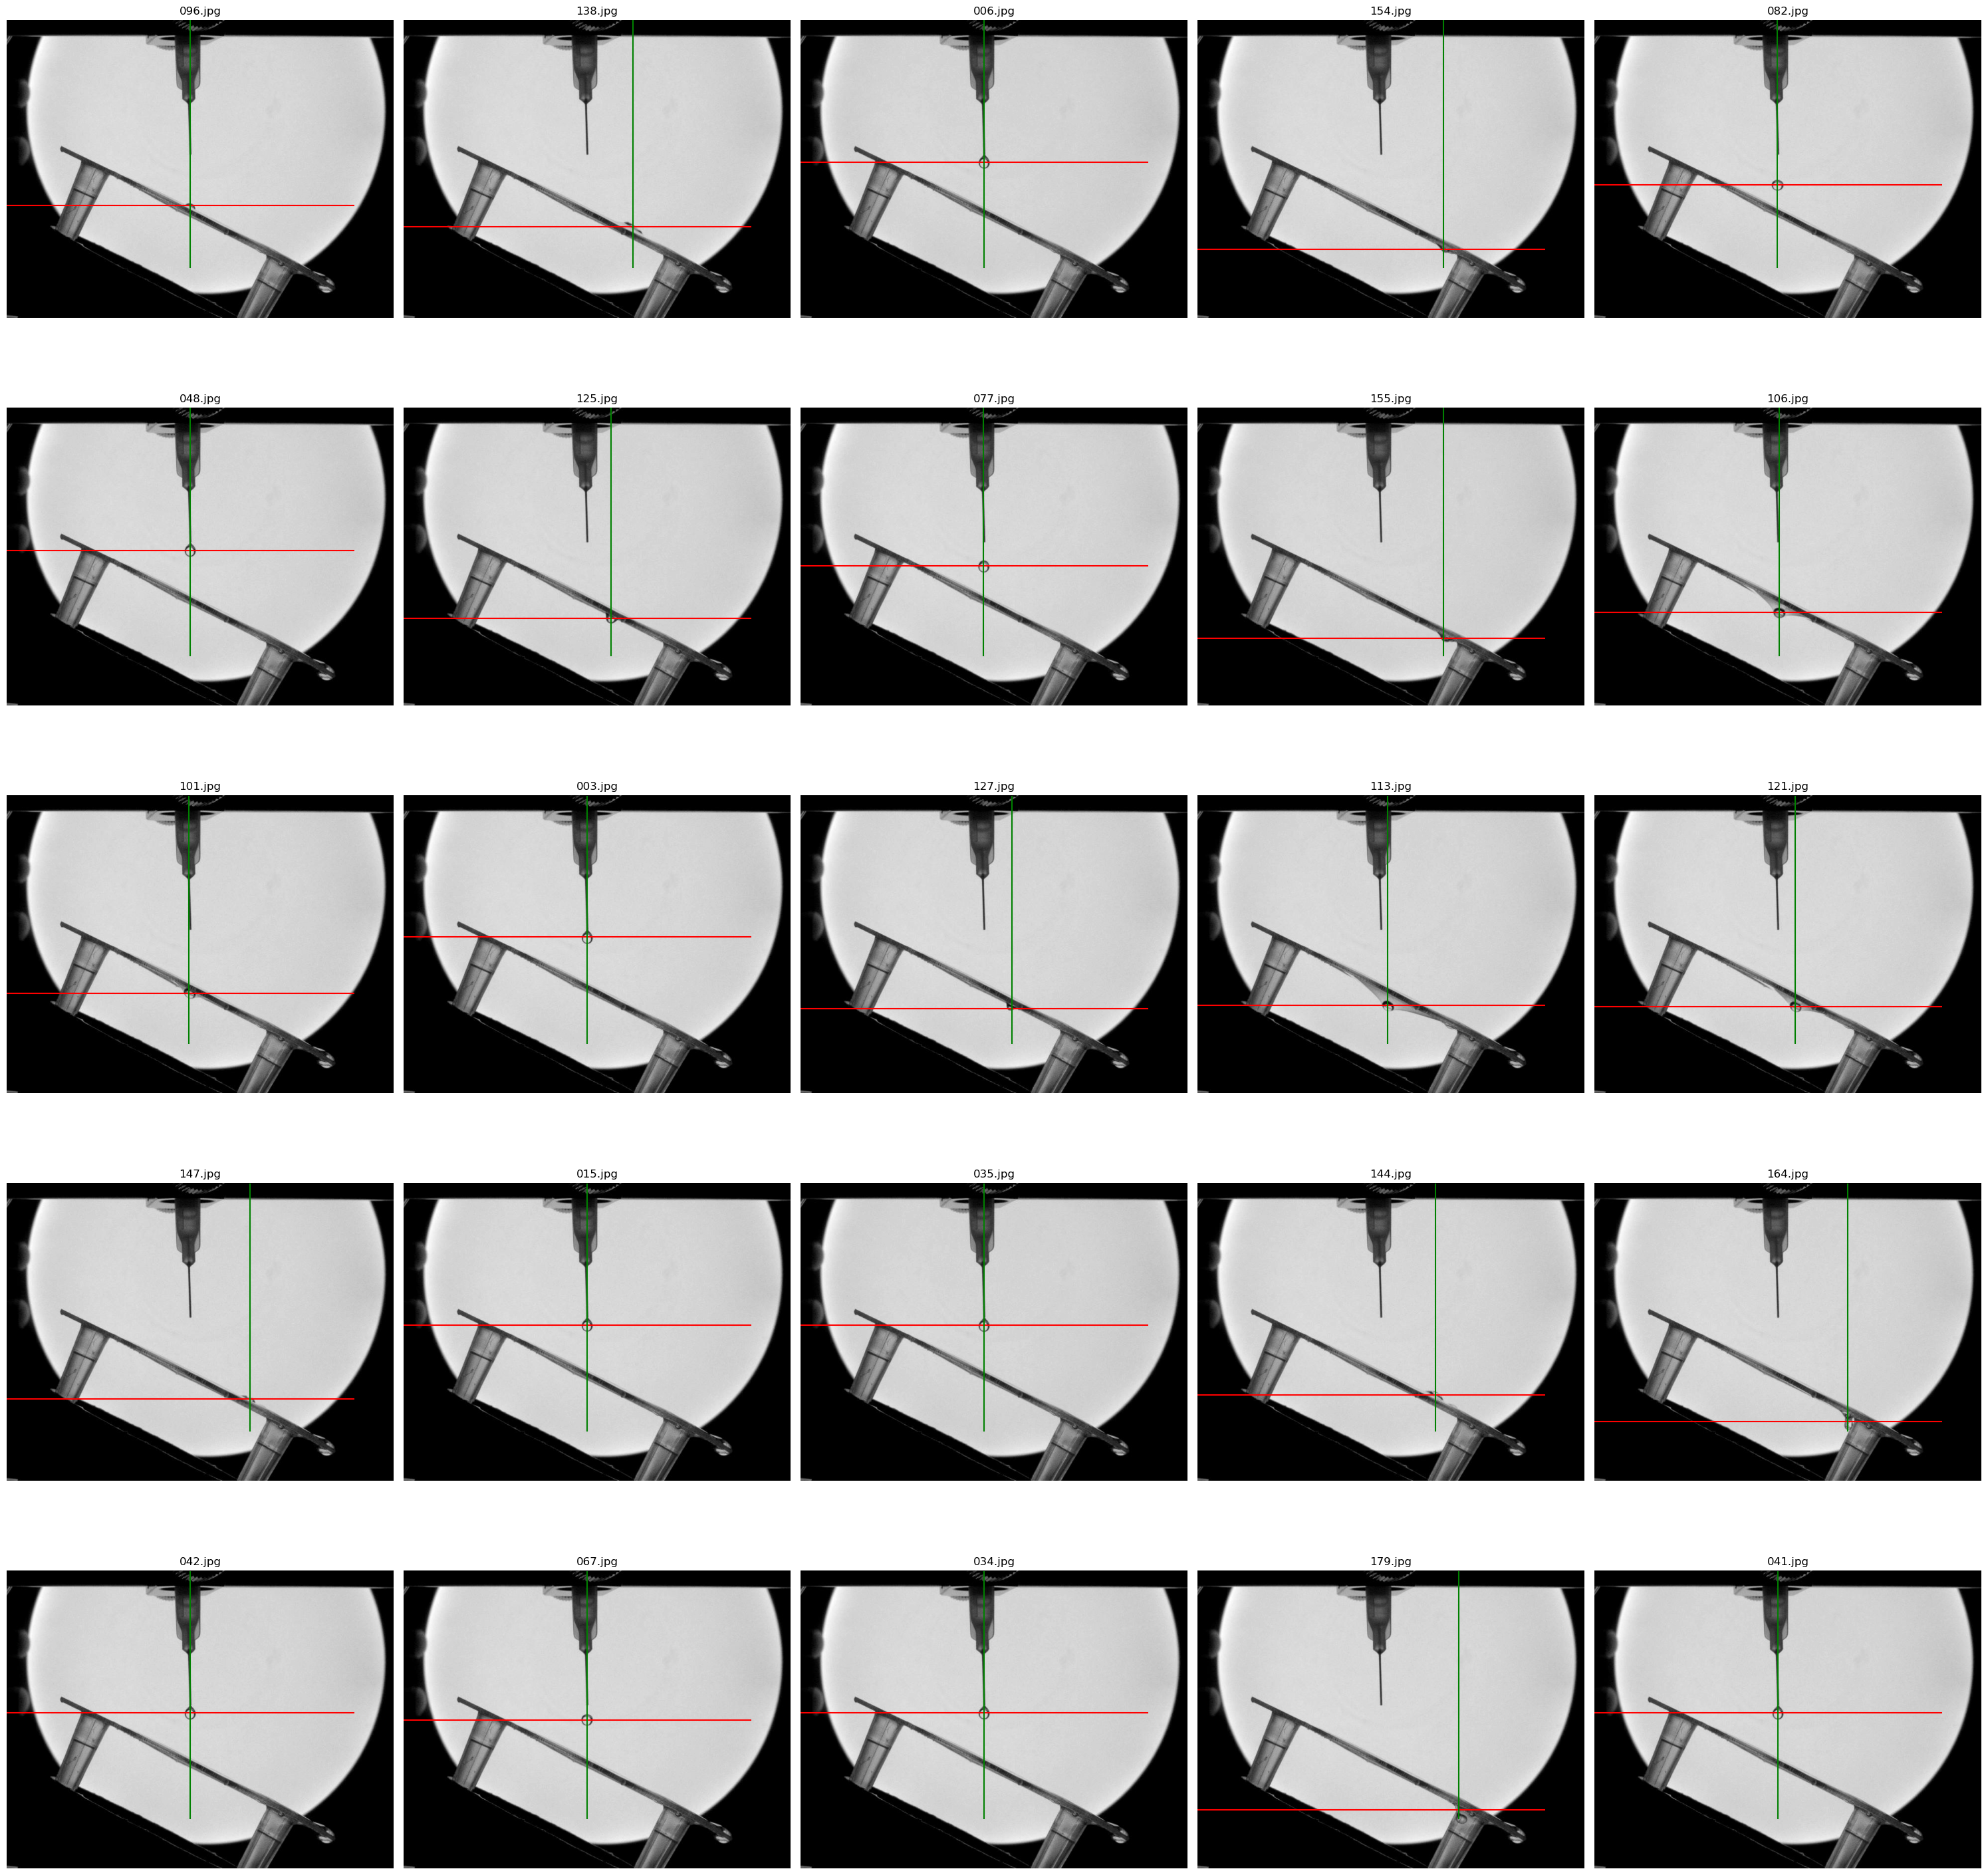

In [102]:
p = Plotter(df, RESULT_DIR)
p.get_samples(25, file_name = f"{sequence}_samples.png")

## Extracting Objectives

### Getting Frame Information

In [103]:
info_dict = {
    "first_frame": 1,
    "last_frame": 2,
    "contact_frame": 3,
    "leave_frame": 4,
    "angle": 5,
}

In [104]:
def update_info(file, info, line_num = 4):
    with open(file, "r") as f:
        texts = f.readlines()
    line = texts[line_num]
    value = line.split(":")[1].strip()
    if value == "":
        line = line.split(":")[0] + ": " + info + "\n"
        texts[line_num] = line
    else:
        texts[line_num] = line
    with open(file, "w") as f:
        f.writelines(texts)
    return texts[line_num]
leave_frame = df[df["y"] == df["y"].max()]["id"].values[-1].split("/")[-1]
last_frame = df.iloc[-10]["id"].split("/")[-1]
update_info(f"{DATA_DIR}.txt", leave_frame, line_num = 4)
update_info(f"{DATA_DIR}.txt", last_frame, line_num = 2)

'### Last Frame ID: 290.jpg\n'

In [105]:
def get_info(file):
    information = {}
    with open(file, "r") as f:
        texts = f.readlines()
    for key, value in info_dict.items():
        line = texts[value]
        info = line.split(":")[1].strip()
        information[key] = info
    return information

information = get_info(f"{DATA_DIR}.txt")

In [106]:
first_frame = DATA_DIR + "/" +information["first_frame"]
last_frame = DATA_DIR + "/" +information["last_frame"]
contact_frame = DATA_DIR + "/" +information["contact_frame"]
angle = information["angle"]
leave_frame = DATA_DIR + "/" +information["leave_frame"]

In [107]:
first_frame, last_frame

('../../data/extracted_images/h2/000.jpg',
 '../../data/extracted_images/h2/290.jpg')

### Getting Angle and Velocity

In [108]:
s = Smoother(df)
df_s = s.smoothen(remove_noise = False)

c:\Users\harik\Desktop\mini-project\codes\extraction\misc_tools.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["r"] = ((df["r1"] + df["r2"]) / 2).astype(int)
c:\Users\harik\Desktop\mini-project\codes\extraction\misc_tools.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = self.savitzky_golay(col_value, window_size=w, order=order)


In [109]:
df = df[df.notna()]
df["vx"] = df["x"].diff(7)/7
df["vy"] = df["y"].diff(7)/7

In [110]:


df.dropna(inplace=True)
df["vy"] = df["vy"].astype(float)
df["vx"] = df["vx"].astype(float)
df["v"] = np.sqrt(df["vx"]**2 + df["vy"]**2)

In [111]:
df_s["vx"] = df_s["x"].diff(7)/7
df_s["vy"] = df_s["y"].diff(7)/7

df_s.dropna(inplace=True)
df_s["v"] = np.sqrt(df_s["vx"]**2 + df_s["vy"]**2)

C:\Users\harik\AppData\Local\Temp\ipykernel_7704\3680160857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s["vx"] = df_s["x"].diff(7)/7
C:\Users\harik\AppData\Local\Temp\ipykernel_7704\3680160857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s["vy"] = df_s["y"].diff(7)/7
C:\Users\harik\AppData\Local\Temp\ipykernel_7704\3680160857.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

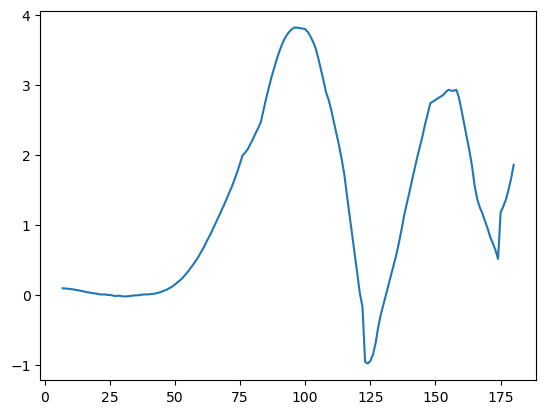

In [112]:
plt.plot(df_s["vy"])

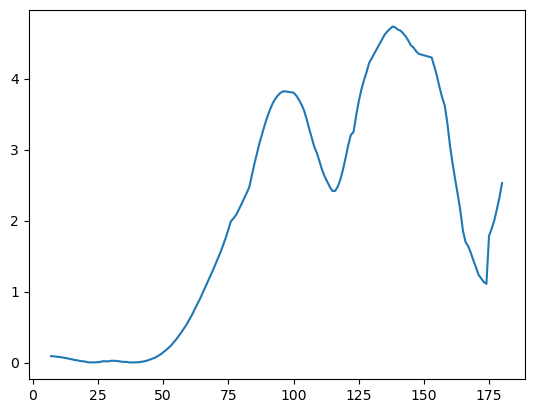

In [113]:
plt.plot(df_s["v"])

In [114]:
def get_angle(row):
    vx = row["vx"]
    vy = -row["vy"]
    if vx == 0 and vy == 0:
        return 0
    elif vx==0:
        return 90
    else:
        return np.arctan(vy/vx)*180/np.pi

In [115]:
df["angle"] = df.apply(get_angle, axis=1)

In [116]:
df_s["angle"] = df_s.apply(get_angle, axis=1)

C:\Users\harik\AppData\Local\Temp\ipykernel_7704\1865048196.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s["angle"] = df_s.apply(get_angle, axis=1)


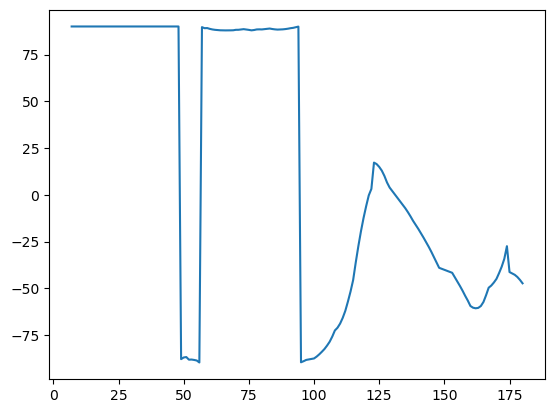

In [117]:
plt.plot(df_s["angle"])

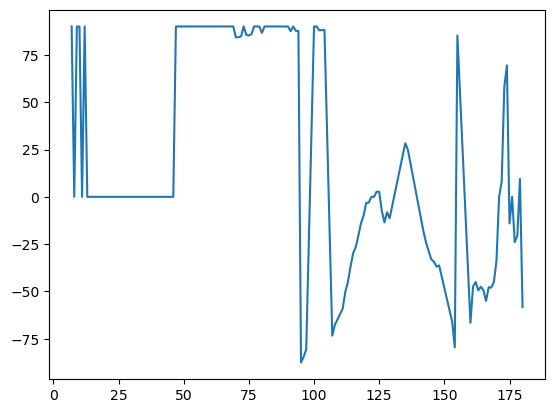

In [118]:
plt.plot(df["angle"])

### The Additional Information

In [119]:
df[df["id"] == contact_frame].T

93
id     ../../data/extracted_images/h2/093.jpg
x                                       867.0
y                                       568.0
r1                                        9.0
r2                                       10.0
theta                                    1.57
vx                                  -0.142857
vy                                   3.571429
v                                    3.574285
angle                                87.70939

In [120]:
df[df["id"] == leave_frame].T

175
id     ../../data/extracted_images/h2/175.jpg
x                                      1023.0
y                                       686.0
r1                                        3.0
r2                                       14.0
theta                                   -0.61
vx                                   1.142857
vy                                   0.285714
v                                     1.17803
angle                              -14.036243

In [121]:
df_s[df_s["id"] == contact_frame].T

93
id     ../../data/extracted_images/h2/093.jpg
x                                  867.283986
y                                  570.098884
r1                                   8.469843
r2                                   9.326716
theta                                1.192297
r                                    8.729438
vx                                  -0.025633
vy                                   3.715096
v                                    3.715184
angle                               89.604688

In [122]:
df_s[df_s["id"] == leave_frame].T

175
id     ../../data/extracted_images/h2/175.jpg
x                                 1024.607298
y                                  691.557383
r1                                   7.416903
r2                                  11.004349
theta                               -0.341221
r                                    7.968236
vx                                   1.341085
vy                                   1.176161
v                                    1.783778
angle                              -41.251462

In [123]:
reg = re.compile(r"\d{3}")
contact_frame_num = int(reg.findall(contact_frame)[0])
leave_frame_num = int(reg.findall(leave_frame)[0])
contact_frame_num, leave_frame_num

(93, 175)

In [134]:
df_s["vy"].loc[leave_frame_num-10:leave_frame_num+10]

165    1.562218
166    1.367285
167    1.249845
168    1.159306
169    1.049699
170    0.946925
171    0.822678
172    0.735354
173    0.638198
174    0.510683
175    1.176161
176    1.260217
177    1.357318
178    1.494503
179    1.657618
180    1.856873
Name: vy, dtype: float64

In [125]:
angle_at_contact_frame = df_s.loc[contact_frame_num]["angle"]
angle_at_leave_frame = df_s.loc[leave_frame_num]["angle"]

if angle_at_contact_frame<0:
    angle_at_contact_frame = 180 + angle_at_contact_frame

angle_at_contact_frame, angle_at_leave_frame

(89.60468772196917, -41.25146217928904)

In [126]:
velocity_at_leave_frame = df_s.loc[leave_frame_num]["v"]
velocity_at_contact_frame = df_s.loc[contact_frame_num]["v"]
velocity_at_leave_frame, velocity_at_contact_frame

(1.7837779710227692, 3.715184448211332)

In [127]:
velocity_at_leave_frame = df.loc[leave_frame_num]["v"]
velocity_at_contact_frame = df.loc[contact_frame_num]["v"]
velocity_at_leave_frame, velocity_at_contact_frame

(1.178030178747903, 3.574284572341944)

In [128]:
x_velocity_at_leave_frame = df.loc[leave_frame_num]["vx"]
x_velocity_at_contact_frame = df.loc[contact_frame_num]["vx"]

y_velocity_at_leave_frame = df.loc[leave_frame_num]["vy"]
y_velocity_at_contact_frame = df.loc[contact_frame_num]["vy"]
x_velocity_at_contact_frame, x_velocity_at_leave_frame, y_velocity_at_contact_frame, y_velocity_at_leave_frame

(-0.14285714285714285,
 1.1428571428571428,
 3.5714285714285716,
 0.2857142857142857)

In [129]:
x_velocity_at_leave_frame = df_s.loc[leave_frame_num]["vx"]
x_velocity_at_contact_frame = df_s.loc[contact_frame_num]["vx"]

y_velocity_at_leave_frame = df_s.loc[leave_frame_num]["vy"]
y_velocity_at_contact_frame = df_s.loc[contact_frame_num]["vy"]

### Adding the Additional Information

In [130]:
pattern = "***"
information = f"""\n{pattern*20}
### TOTAL FRAMES: {total_frames}
### NONE FRAMES: {none_values}
### UNREALISTIC FRAMES: {unrealistic}
{pattern*20}
AT CONTACT FRAME:
### ANGLE: {np.round(-90+angle_at_contact_frame+float(angle), 2)}
### VELOCITY: {np.round(velocity_at_contact_frame, 2)}
### X VELOCITY: {np.round(x_velocity_at_contact_frame, 2)}
### Y VELOCITY: {np.round(y_velocity_at_contact_frame, 2)}

AT LEAVE FRAME:
### ANGLE: {np.round(angle_at_leave_frame, 2)}
### VELOCITY: {np.round(velocity_at_leave_frame, 2)}
### X VELOCITY: {np.round(x_velocity_at_leave_frame, 2)}
### Y VELOCITY: {np.round(y_velocity_at_leave_frame, 2)}
{pattern*20}"""
print(information)


************************************************************
### TOTAL FRAMES: 300
### NONE FRAMES: 130
### UNREALISTIC FRAMES: 4
************************************************************
AT CONTACT FRAME:
### ANGLE: 26.6
### VELOCITY: 3.57
### X VELOCITY: -0.03
### Y VELOCITY: 3.72

AT LEAVE FRAME:
### ANGLE: -41.25
### VELOCITY: 1.18
### X VELOCITY: 1.34
### Y VELOCITY: 1.18
************************************************************


First, remove anything between the asterisks.

In [131]:
with open(DATA_DIR+".txt", "r") as f:
    texts = f.readlines()
text = "".join(texts[:6])
print(text)
all_text = text+information

### h2.tif
### First Frame ID: 000.jpg
### Last Frame ID: 290.jpg
### Contact Frame ID: 093.jpg
### Leave Frame ID: 175.jpg
### Angle: 27



In [132]:
with open(RESULT_DIR +"/info.txt", "w") as f:
    f.writelines(all_text)

### Save the DataFrame

In [133]:
df_s.to_csv(RESULT_DIR + f"/{sequence}_smoothened.csv", index=False)